In [2]:
%matplotlib inline
from imports import *
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
order = ['node','Python','Ruby']
d = {'python':'Python','ruby':'Ruby'}
import effect_size
from tqdm.notebook import tqdm

## Start with analysis at the release date

In [3]:
lag_release = pd.read_csv('../data/lag_release.csv')
lag_release.package.fillna('nan', inplace=True)
lag_release['last_updated'] = pd.to_datetime(lag_release['last_updated'])

In [4]:
# Filter on 3000 images
candidates_3000 = pd.read_csv('../data/considered_3000_images.csv')
mask = lag_release.image.isin(candidates_3000.image)
lag_release = lag_release[mask]
lag_release['base'] = lag_release['base'].replace(d)
lag_release.rename(columns = {'operating':'os'}, inplace=True)

# node images might have transitive dependencies, or the same version can be python2 or python3
lag_release.drop_duplicates(inplace=True)

len(lag_release)

472522

## Technical lag at the release date

In [5]:
lag_release['last_updated'] = pd.to_datetime(lag_release['last_updated'])
for x in ['major','minor','patch']:
    lag_release[x] = lag_release[x].apply(float)

In [6]:
lag_release['lag'] = lag_release.apply(lambda d : 'major' if d['major'] >0
                                      else 'minor' if d['minor'] >0
                                      else 'patch' if d['patch'] >0
                                      else "up-to-date", axis=1)

In [7]:
# Not core packages
added_package = lag_release.query('core == False')

# ALL PACKAGES

In [ ]:
### ALL PACKAGES
df_tmp = lag_release[['image','base','last_updated','core','package','lag']]
#df_tmp = df_tmp.query('base!="Python"')
df_tmp['update'] = df_tmp['lag'].apply(lambda x: 'outdated' if x!='up-to-date'
                                      else x)
df_tmp = (df_tmp
          .groupby(['image','base','last_updated','update','core'])
          .count()[['package']]
          .reset_index()
          .merge(df_tmp
                 .groupby(['image','base','last_updated','core'])
                 .count()[['package']]
                 .reset_index()
                 .rename(columns ={'package':'all'}),
                 on = ['image','base','last_updated','core'],
                 how = 'left'
                )
         )
df_tmp['package'] = df_tmp.apply(lambda d: d['package']*1.0/d['all'], axis=1)

# The ones with 0 will not be shown
df_tmp = (pd.concat([df_tmp[['image','base','last_updated','core']].drop_duplicates().assign(update = ver) for ver in df_tmp['update'].unique().tolist()])
      .merge(df_tmp,
             on = ['image','base','last_updated','update','core'],
             how = 'left'
            )
     )
df_tmp.fillna(0, inplace=True)

df_tmp['year'] = df_tmp['last_updated'].apply(lambda x: x.year)
df_tmp['core'] = df_tmp['core'].replace({True:'Core', False:'Non-core'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


([<matplotlib.axis.YTick at 0x7f4565bc41d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

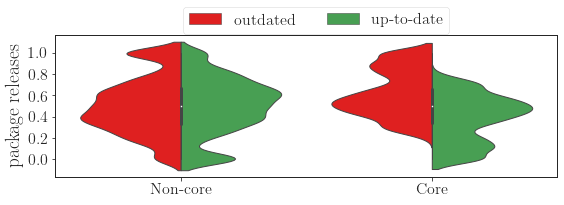

In [9]:
ax = sns.violinplot(x="core", 
                 y="package",
                   hue='update',
                 data=df_tmp,#.query('base =="{}"'.format(base)),
                   palette = [colors['major'],colors['up-to-date']],
                 linewidth=1,
                    split=True
                  )
ax.set(
    xlabel='',
    ylabel='package releases',
)
ax.legend(ncol=4, prop={'size': 16, 'weight':'bold'}, bbox_to_anchor= (0.8, 1.26))
#ax.legend(loc='lower center')
ax.figure.set_size_inches(9,2.6)
plt.yticks(pd.np.arange(0, 1.01, 0.2))  

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  app.launch_new_instance()


([<matplotlib.axis.YTick at 0x7f45a5457cf8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

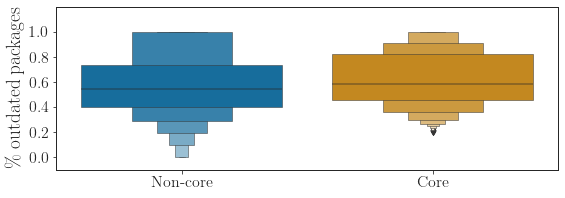

In [10]:
ax = sns.boxenplot(y="package",
                x='core',
                 data=df_tmp.query('update=="outdated" and base != "Python"'),
                 linewidth=1,
                  )
ax.set(
    xlabel='',
    ylabel='\% outdated packages',
    ylim=(-0.1,1.2),
)
ax.legend().remove()
ax.figure.set_size_inches(9,3)
plt.yticks(pd.np.arange(0, 1.01, 0.2))  

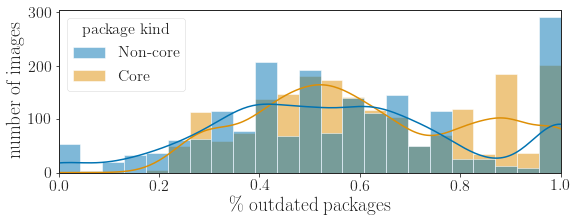

In [11]:
df_tmp['package kind'] = df_tmp['core']
ax = sns.histplot(df_tmp.query('update=="outdated" and base != "Python"'), x='package', 
             hue='package kind', kde=True)

ax.set(
    xlabel='\% outdated packages',
    ylabel='number of images',
    xlim=(0,1)
)
ax.figure.set_size_inches(9,3)

In [12]:
df_tmp.groupby(['core','update'])['package'].describe()

count      mean       std       min       25%       50%  \
core     update                                                                 
Core     outdated    2000.0  0.621436  0.222205  0.205882  0.456989  0.583333   
         up-to-date  2000.0  0.378564  0.222205  0.000000  0.181818  0.416667   
Non-core outdated    2929.0  0.501149  0.267787  0.000000  0.316940  0.500000   
         up-to-date  2929.0  0.498851  0.267787  0.000000  0.333333  0.500000   

                          75%       max  
core     update                          
Core     outdated    0.818182  1.000000  
         up-to-date  0.543011  0.794118  
Non-core outdated    0.666667  1.000000  
         up-to-date  0.683060  1.000000

In [13]:
print(len(df_tmp.query('core == "Non-core" and update =="outdated" and package =="1"')))
(df_tmp
 .query('core == "Non-core" and update =="outdated" and package =="1"')
 .groupby('base')
 .count()[['image']]
)

323


,image
base,
Python,32
Ruby,291


In [14]:
print(len(df_tmp.query('core == "Core" and update=="outdated" and package =="1"')))
(df_tmp
 .query('core == "Non-core" and update =="outdated" and package =="1"')
 .groupby('base')
 .count()[['image']]
)

201


,image
base,
Python,32
Ruby,291


In [15]:
# Mann-whitney u test
scipy.stats.mannwhitneyu(df_tmp.query('core =="Non-core" and update=="outdated"').package,
                        df_tmp.query('core =="Core" and update=="outdated"').package)

MannwhitneyuResult(statistic=2147815.0, pvalue=1.812456229021184e-57)

In [16]:
# Effect size
effect_size.cliffsDelta(df_tmp.query('core =="Non-core" and update=="outdated"').package,
                        df_tmp.query('core =="Core" and update=="outdated"').package)

d=-0.26670706725845


True

In [19]:
# Mann-whitney u test
for type2 in ['Non-core','Core']:
    print(type2,scipy.stats.mannwhitneyu(df_tmp.query('core =="'+type2+'" and update=="up-to-date"').package,
                                        df_tmp.query('core =="'+type2+'" and update=="outdated"').package))

Non-core MannwhitneyuResult(statistic=4164809.0, pvalue=0.02690118277590407)
Core MannwhitneyuResult(statistic=977705.0, pvalue=8.576979353645433e-173)


In [20]:
# Effect size
for type2 in ['Non-core','Core']:
    print(type2,effect_size.cliffsDelta(df_tmp.query('core =="'+type2+'" and update=="up-to-date"').package,
                                        df_tmp.query('core =="'+type2+'" and update=="outdated"').package))

d=0.029073529314057364
Non-core False
d=-0.5111475
Core True


### Let's compare by base

In [21]:
### ALL PACKAGES
df_tmp = lag_release[['image','base','last_updated','package','lag']]
df_tmp = (df_tmp
          .groupby(['image','base','last_updated','lag'])
          .count()[['package']]
          .reset_index()
          .merge(df_tmp
                 .groupby(['image','base','last_updated'])
                 .count()[['package']]
                 .reset_index()
                 .rename(columns ={'package':'all'}),
                 on = ['image','base','last_updated'],
                 how = 'left'
                )
         )
df_tmp['package'] = df_tmp.apply(lambda d: d['package']*1.0/d['all'], axis=1)

# The ones with 0 will not be shown
df_tmp = (pd.concat([df_tmp[['image','base','last_updated']].drop_duplicates().assign(lag = ver) for ver in df_tmp['lag'].unique().tolist()])
      .merge(df_tmp,
             on = ['image','base','last_updated','lag'],
             how = 'left'
            )
     )
df_tmp.fillna(0, inplace=True)

df_tmp['year'] = df_tmp['last_updated'].apply(lambda x: x.year)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


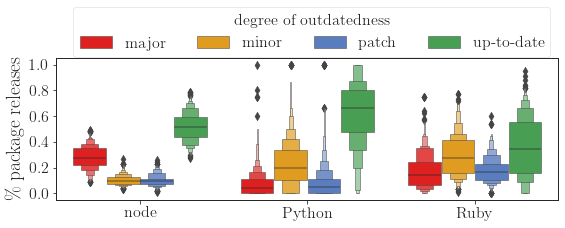

In [23]:
ax = sns.boxenplot(x="base", 
                 y="package",
                   hue='lag',
                 hue_order = ['major','minor','patch','up-to-date'],
                   order = order,
                 data=df_tmp,#.query('base =="{}"'.format(base)),
                 palette=[colors[r] for r in ['major','minor','patch','up-to-date']] ,
                 linewidth=1,
                  )
ax.set(
    xlabel='',
    ylabel='\% package releases',
)
ax.legend(ncol=4, bbox_to_anchor= (1, 1.42), prop={'size': 16, 'weight':'bold'},  title='degree of outdatedness')
ax.figure.set_size_inches(9,2.6)
plt.yticks(pd.np.arange(0, 1.01, 0.2))  

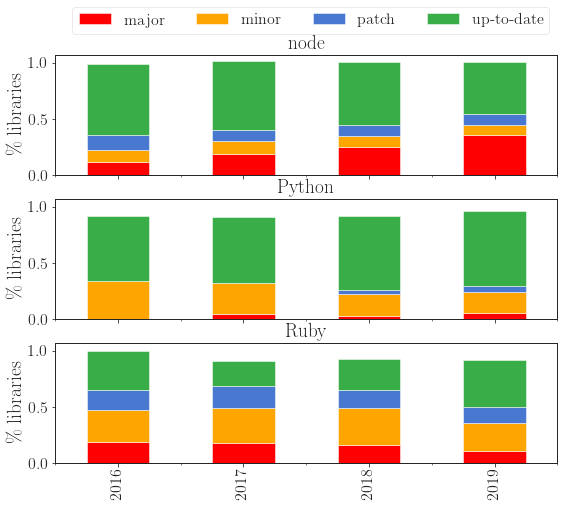

In [24]:
import matplotlib.pylab as pylab
params = {'axes.titlesize':'large',
         'axes.titleweight':'bold'}
plt.rcParams.update(params)
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_size_inches(9,7.5)
for i, base in enumerate(order):
    df_ = (df_tmp.query('base == "'+base+'"')
     .groupby(['year','lag'])['package']
     .describe()[['50%']] # MEDIAN
     .rename(columns={'50%':'median'})
     .reset_index()
     .pivot_table(index=['year'], columns='lag', values='median')
     .reset_index()
     .set_index('year')
    )
    ax = df_.plot.bar(stacked=True, color = [colors[r] for r in ['major','minor','patch','up-to-date']], ax=axes[i])
    ax.set(
        xlabel='',
        ylabel='\% libraries',
        title=base,
    )
        
    ax.legend().remove()
ax.legend(ncol=4, prop={'size': 16, 'weight':'bold'}, bbox_to_anchor= (1, 3.87))

In [25]:
df_tmp.groupby(['base','lag'])['package'].describe()

count      mean       std       min       25%       50%  \
base   lag                                                                    
Python major       1000.0  0.070436  0.099159  0.000000  0.000000  0.042828   
       minor       1000.0  0.228415  0.177599  0.000000  0.104809  0.200000   
       patch       1000.0  0.079189  0.121883  0.000000  0.000000  0.044447   
       up-to-date  1000.0  0.621961  0.241822  0.000000  0.477926  0.665537   
Ruby   major       1000.0  0.163350  0.128285  0.000000  0.061460  0.138309   
       minor       1000.0  0.297131  0.162256  0.011976  0.159038  0.275862   
       patch       1000.0  0.178000  0.096983  0.000000  0.102215  0.163214   
       up-to-date  1000.0  0.361519  0.233748  0.000000  0.153846  0.347826   
node   major       1000.0  0.279694  0.087387  0.083700  0.220159  0.275956   
       minor       1000.0  0.101414  0.037480  0.031359  0.074271  0.095560   
       patch       1000.0  0.101590  0.043253  0.009662  0.070308  0.098143   
       up-to-date  1000.0  0.517302  0.111700  0.277228  0.438307  0.516021   

                        75%       max  
base   lag                             
Python major       0.108547  1.000000  
       minor       0.333333  1.000000  
       patch       0.111111  1.000000  
       up-to-date  0.800000  1.000000  
Ruby   major       0.239473  0.750000  
       minor       0.417151  0.769231  
       patch       0.224846  0.600000  
       up-to-date  0.554552  0.952096  
node   major       0.352459  0.489071  
       minor       0.122951  0.265683  
       patch       0.112253  0.261307  
       up-to-date  0.592105  0.789941

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


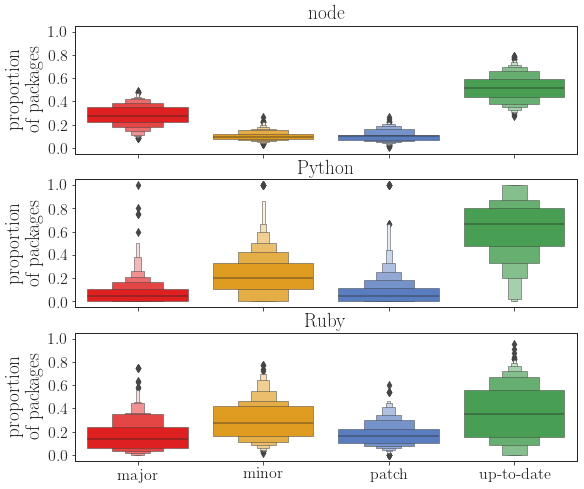

In [26]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_size_inches(9,8)
for i, base in enumerate(order):
    ax = sns.boxenplot(x="lag", 
                     y="package",
                     order = ['major','minor','patch','up-to-date'],
                     data=df_tmp.query('base =="{}"'.format(base)),
                     palette=[colors[r] for r in ['major','minor','patch','up-to-date']] , 
                     linewidth=1,
                     ax=axes[i]
                      )
    ax.set(
        xlabel='',
        ylabel='proportion \nof packages',
        title=base,
    )
    plt.yticks(pd.np.arange(0, 1.01, 0.2))  

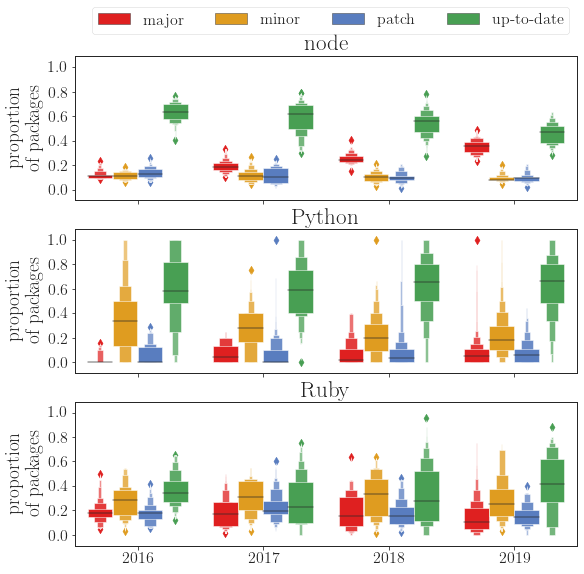

In [237]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_size_inches(9,9)
for i, base in enumerate(order):
    ax = sns.boxenplot(x="year", 
                     y="package",
                       hue='lag',
                     hue_order = ['major','minor','patch','up-to-date'],
                     data=df_tmp.query('base =="{}"'.format(base)),
                     palette=[colors[r] for r in ['major','minor','patch','up-to-date']] , 
                     linewidth=1,
                     ax=axes[i]
                      )
    ax.set(
        xlabel='',
        ylabel='proportion \nof packages',
        title=base,
    )

    plt.yticks(pd.np.arange(0, 1.01, 0.2)) 
    ax.legend().remove()
ax.legend(ncol=4, prop={'size': 16, 'weight':'bold'}, bbox_to_anchor= (1, 3.8))

### NOT CORE PACKAGES

In [239]:
### ADDED PACKAGES
df_tmp = added_package[['image','base','last_updated','package','lag']]
df_tmp = (df_tmp
          .groupby(['image','base','last_updated','lag'])
          .count()[['package']]
          .reset_index()
          .merge(df_tmp
                 .groupby(['image','base','last_updated'])
                 .count()[['package']]
                 .reset_index()
                 .rename(columns ={'package':'all'}),
                 on = ['image','base','last_updated'],
                 how = 'left'
                )
         )
df_tmp['package'] = df_tmp.apply(lambda d: d['package']*1.0/d['all'], axis=1)

# The ones with 0 will not be shown
df_tmp = (pd.concat([df_tmp[['image','base','last_updated']].drop_duplicates().assign(lag = ver) for ver in df_tmp['lag'].unique().tolist()])
      .merge(df_tmp,
             on = ['image','base','last_updated','lag'],
             how = 'left'
            )
     )
df_tmp.fillna(0, inplace=True)

df_tmp['year'] = df_tmp['last_updated'].apply(lambda x: x.year)

([<matplotlib.axis.YTick at 0x7f3b372707b8>,
 <a list of 6 Text yticklabel objects>)

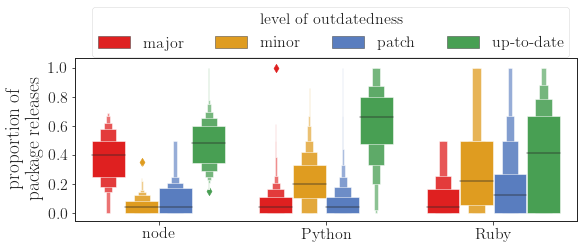

In [240]:
ax = sns.boxenplot(x="base", 
                 y="package",
                   hue='lag',
                 hue_order = ['major','minor','patch','up-to-date'],
                   order = order,
                 data=df_tmp,#.query('base =="{}"'.format(base)),
                 palette=[colors[r] for r in ['major','minor','patch','up-to-date']] ,
                 linewidth=1,
                  )
ax.set(
    xlabel='',
    ylabel='proportion of \npackage releases',
)
ax.legend(ncol=4, bbox_to_anchor= (1, 1.36), prop={'size': 16, 'weight':'bold'},  title='level of outdatedness')
ax.figure.set_size_inches(9,3)
plt.yticks(pd.np.arange(0, 1.01, 0.2))  

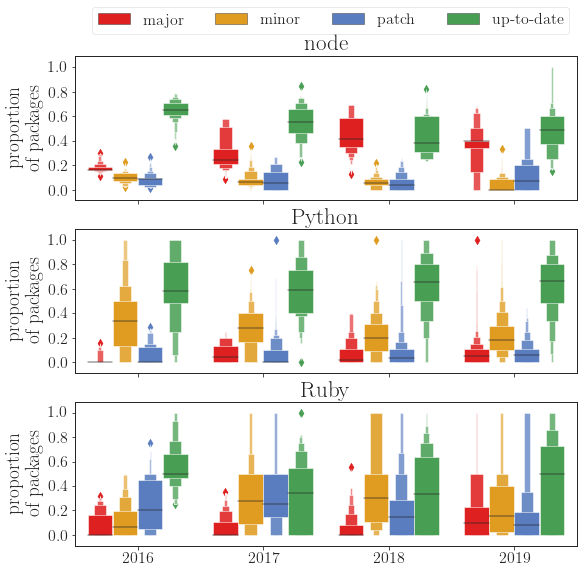

In [241]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_size_inches(9,9)
for i, base in enumerate(order):
    ax = sns.boxenplot(x="year", 
                     y="package",
                       hue='lag',
                     hue_order = ['major','minor','patch','up-to-date'],
                     data=df_tmp.query('base =="{}"'.format(base)),
                     palette=[colors[r] for r in ['major','minor','patch','up-to-date']] , 
                     linewidth=1,
                     ax=axes[i]
                      )
    ax.set(
        xlabel='',
        ylabel='proportion \nof packages',
        title=base,
    )

    plt.yticks(pd.np.arange(0, 1.01, 0.2)) 
    ax.legend().remove()
ax.legend(ncol=4, prop={'size': 16, 'weight':'bold'}, bbox_to_anchor= (1, 3.8))